In [1]:
import h5py as h5
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
import legwork

import sys
sys.path.append("../src/")
from variations import variations
from galaxy import simulate_mw

%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [2]:
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2), 
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

dco_types = ["BHBH", "BHNS", "NSNS"]
sim_folder = "../data/simulation_plus_channels/"

total_DCOs_in_MW = np.load("../data/total_DCO_in_MW.npy")
total_bound_DCOs_in_MW = np.load("../data/total_DCO_in_MW_nohubble.npy")

detections = np.load("../data/detections_4yr.npy")
detections_10yr = np.load("../data/detections_10yr.npy")

In [5]:
def sky_localisation(snr, fGW, L=2*u.AU):
    sigma_theta = 16.6 * (7 / snr) * (5e-4 * u.Hz / fGW) * (2 * u.AU / L) * u.deg
    return sigma_theta.to(u.deg)

def f_uncertainty(snr, t_obs, f):
    return (4 * np.sqrt(3) / np.pi / (snr * t_obs) / f).decompose()

def fdot_uncertainty(snr, t_obs, fdot):
    return (6 * np.sqrt(5) / np.pi / (snr * t_obs**2) / fdot).decompose()

def Fprime_over_F(e):
    return e * (1256 + 1608 * e**2 + 111 * e**4) / (96 + 196 * e**2 - 255 * e**4 - 37 * e**6)

In [6]:
def distribution_pdf_grid_plot_bymodel(dco_type="BHNS", models=range(len(variations)),
                                       t_obs=4*u.yr, overlay_single_mass_pdfs=False):
    fig, axes = plt.subplots(2, 3, figsize=(25, 15))

    plt.subplots_adjust(wspace=0.05, top=0.87)

    lw = 4
    label_type = "short"

    for model in models:
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

            data = full_data[snr_mask]
            
        print(model, len(data))

        m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
        f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                              a=data["a_LISA"] * u.AU)
        f_dot = legwork.utils.fn_dot(m_c=m_c, f_orb=f_orb_LISA, e=data["e_LISA"], n=1)
        sigma_theta = sky_localisation(data["snr"], f_orb_LISA * 2).to(u.deg)
        
        t_merge = legwork.evol.get_t_merge_ecc(ecc_i=data["e_DCO"], a_i=data["a_DCO"] * u.AU,
                                          m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun).to(u.Gyr)

        if dco_type == "BHNS":
            mBH = np.maximum(data["m_1"], data["m_2"])
            mNS = np.minimum(data["m_1"], data["m_2"])
            mass_weights = data["weight"]
        elif dco_type == "BHBH":
            mBH = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
        elif dco_type == "NSNS":
            mNS = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            
        if dco_type in ["BHNS", "BHBH"]:
            sns.kdeplot(mBH, weights=mass_weights, ax=axes[0, 0], bw_adjust=1.5, color=variations[model]["colour"], lw=lw, label=variations[model]["med"])
            axes[0, 0].set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
            axes[0, 0].set_xlim(2, 15)

        if dco_type == "BHBH" and overlay_single_mass_pdfs:
            twinned = axes[0, 0].twinx()
            sns.kdeplot(data["m_1"], weights=data["weight"], ax=twinned, bw_adjust=1.5, color=variations[model]["colour"], label=variations[model]["med"], linestyle="dotted")
            sns.kdeplot(data["m_2"], weights=data["weight"], ax=twinned, bw_adjust=1.5, color=variations[model]["colour"], label=variations[model]["med"], linestyle="dotted")
            twinned.set_xlim(axes[0,0].get_xlim())
            twinned.set_ylim(axes[0, 0].get_ylim()[0], axes[0, 0].get_ylim()[1] * 3)
            twinned.set_yticks([])
            twinned.set_ylabel("")

        if dco_type in ["BHNS", "NSNS"]:
            sns.kdeplot(mNS, weights=mass_weights, ax=axes[0, 1], bw_adjust=0.8, color=variations[model]["colour"], cut=0, lw=lw, label=variations[model]["med"])
            axes[0, 1].set_xlabel(r"Neutron Star Mass, $m_{\rm NS} \, [\rm M_{\odot}]$")
            axes[0, 1].set_xlim(1.26, 2.5)

        sns.kdeplot(data["e_LISA"], weights=data["weight"], ax=axes[0, 2], bw_adjust=0.5, color=variations[model]["colour"], cut=0, lw=lw, label=variations[model]["med"], log_scale=True)
        axes[0, 2].set_xlabel(r"Eccentricity $\log_{10}(e_{\rm LISA})$")
        axes[0, 2].set_xlim(9e-4, 1)
    
        sns.kdeplot(np.log10(f_orb_LISA.value), weights=data["weight"], ax=axes[1, 0], bw_adjust=1, color=variations[model]["colour"], cut=0, lw=lw, label=variations[model]["med"])
        axes[1, 0].set_xlabel(r"Orbital Frequency, $\log_{10}(f_{\rm orb, LISA} / {\rm Hz})$")
        axes[1, 0].set_xlim(-5.9, -1.8)

        sns.kdeplot(data["dist"], weights=data["weight"], ax=axes[1, 1], bw_adjust=1, color=variations[model]["colour"], cut=0, lw=lw, label=variations[model]["med"])
        axes[1, 1].set_xlabel(r"Luminosity Distance, $D_{\rm L} \, [\rm kpc]$")
        axes[1, 1].set_xlim(0, 25)
        axes[1, 1].axvline(8.2, color="grey", linestyle="dotted", zorder=0)
        axes[1, 1].annotate("Milky Way Centre", xy=(8.2, 0.05), color="grey", rotation=90, ha="center", va="center",
                            bbox=dict(boxstyle="round", ec="white", fc="white"), fontsize=0.55*fs)
        
        sns.kdeplot(t_merge.value, weights=data["weight"], ax=axes[1, 2], bw_adjust=1, color=variations[model]["colour"], lw=lw, label=variations[model]["med"], cut=0)
        axes[1, 2].set_xlabel(r"Inspiral Time, $t_{\rm inspiral} \, [\rm Gyr]$")
        axes[1, 2].set_xlim(0, 12)
        
#         sns.kdeplot(np.log10(data["Z"]), weights=data["weight"], ax=axes[1, 2], cut=0, bw_adjust=1.5, color=dco_colours[dco_type], lw=lw, label=dco_type)
        
    tau, D, Z = simulate_mw(int(1e6))
    sns.kdeplot(D, ax=axes[1, 1], color="grey", bw_adjust=1.5, linestyle="dotted", cut=0)
    
    handles, labels = axes[1, 2].get_legend_handles_labels()
    leg = fig.legend(handles, labels, loc='upper center', fontsize=fs, ncol=8, borderaxespad=0.0,
                     title=dco_type, title_fontsize=1.2 * fs)

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.7*fs)
        ax.set_yticks([])
        ax.set_ylabel("")
        ax.xaxis.label.set_fontsize(fs)

    plt.show()

0 26657
1 26700
2 27936
3 30872
4 26490
5 24552
6 32779
7 21719
8 25268
9 25084
10 28900
11 26562
12 22805
13 20728
14 20384


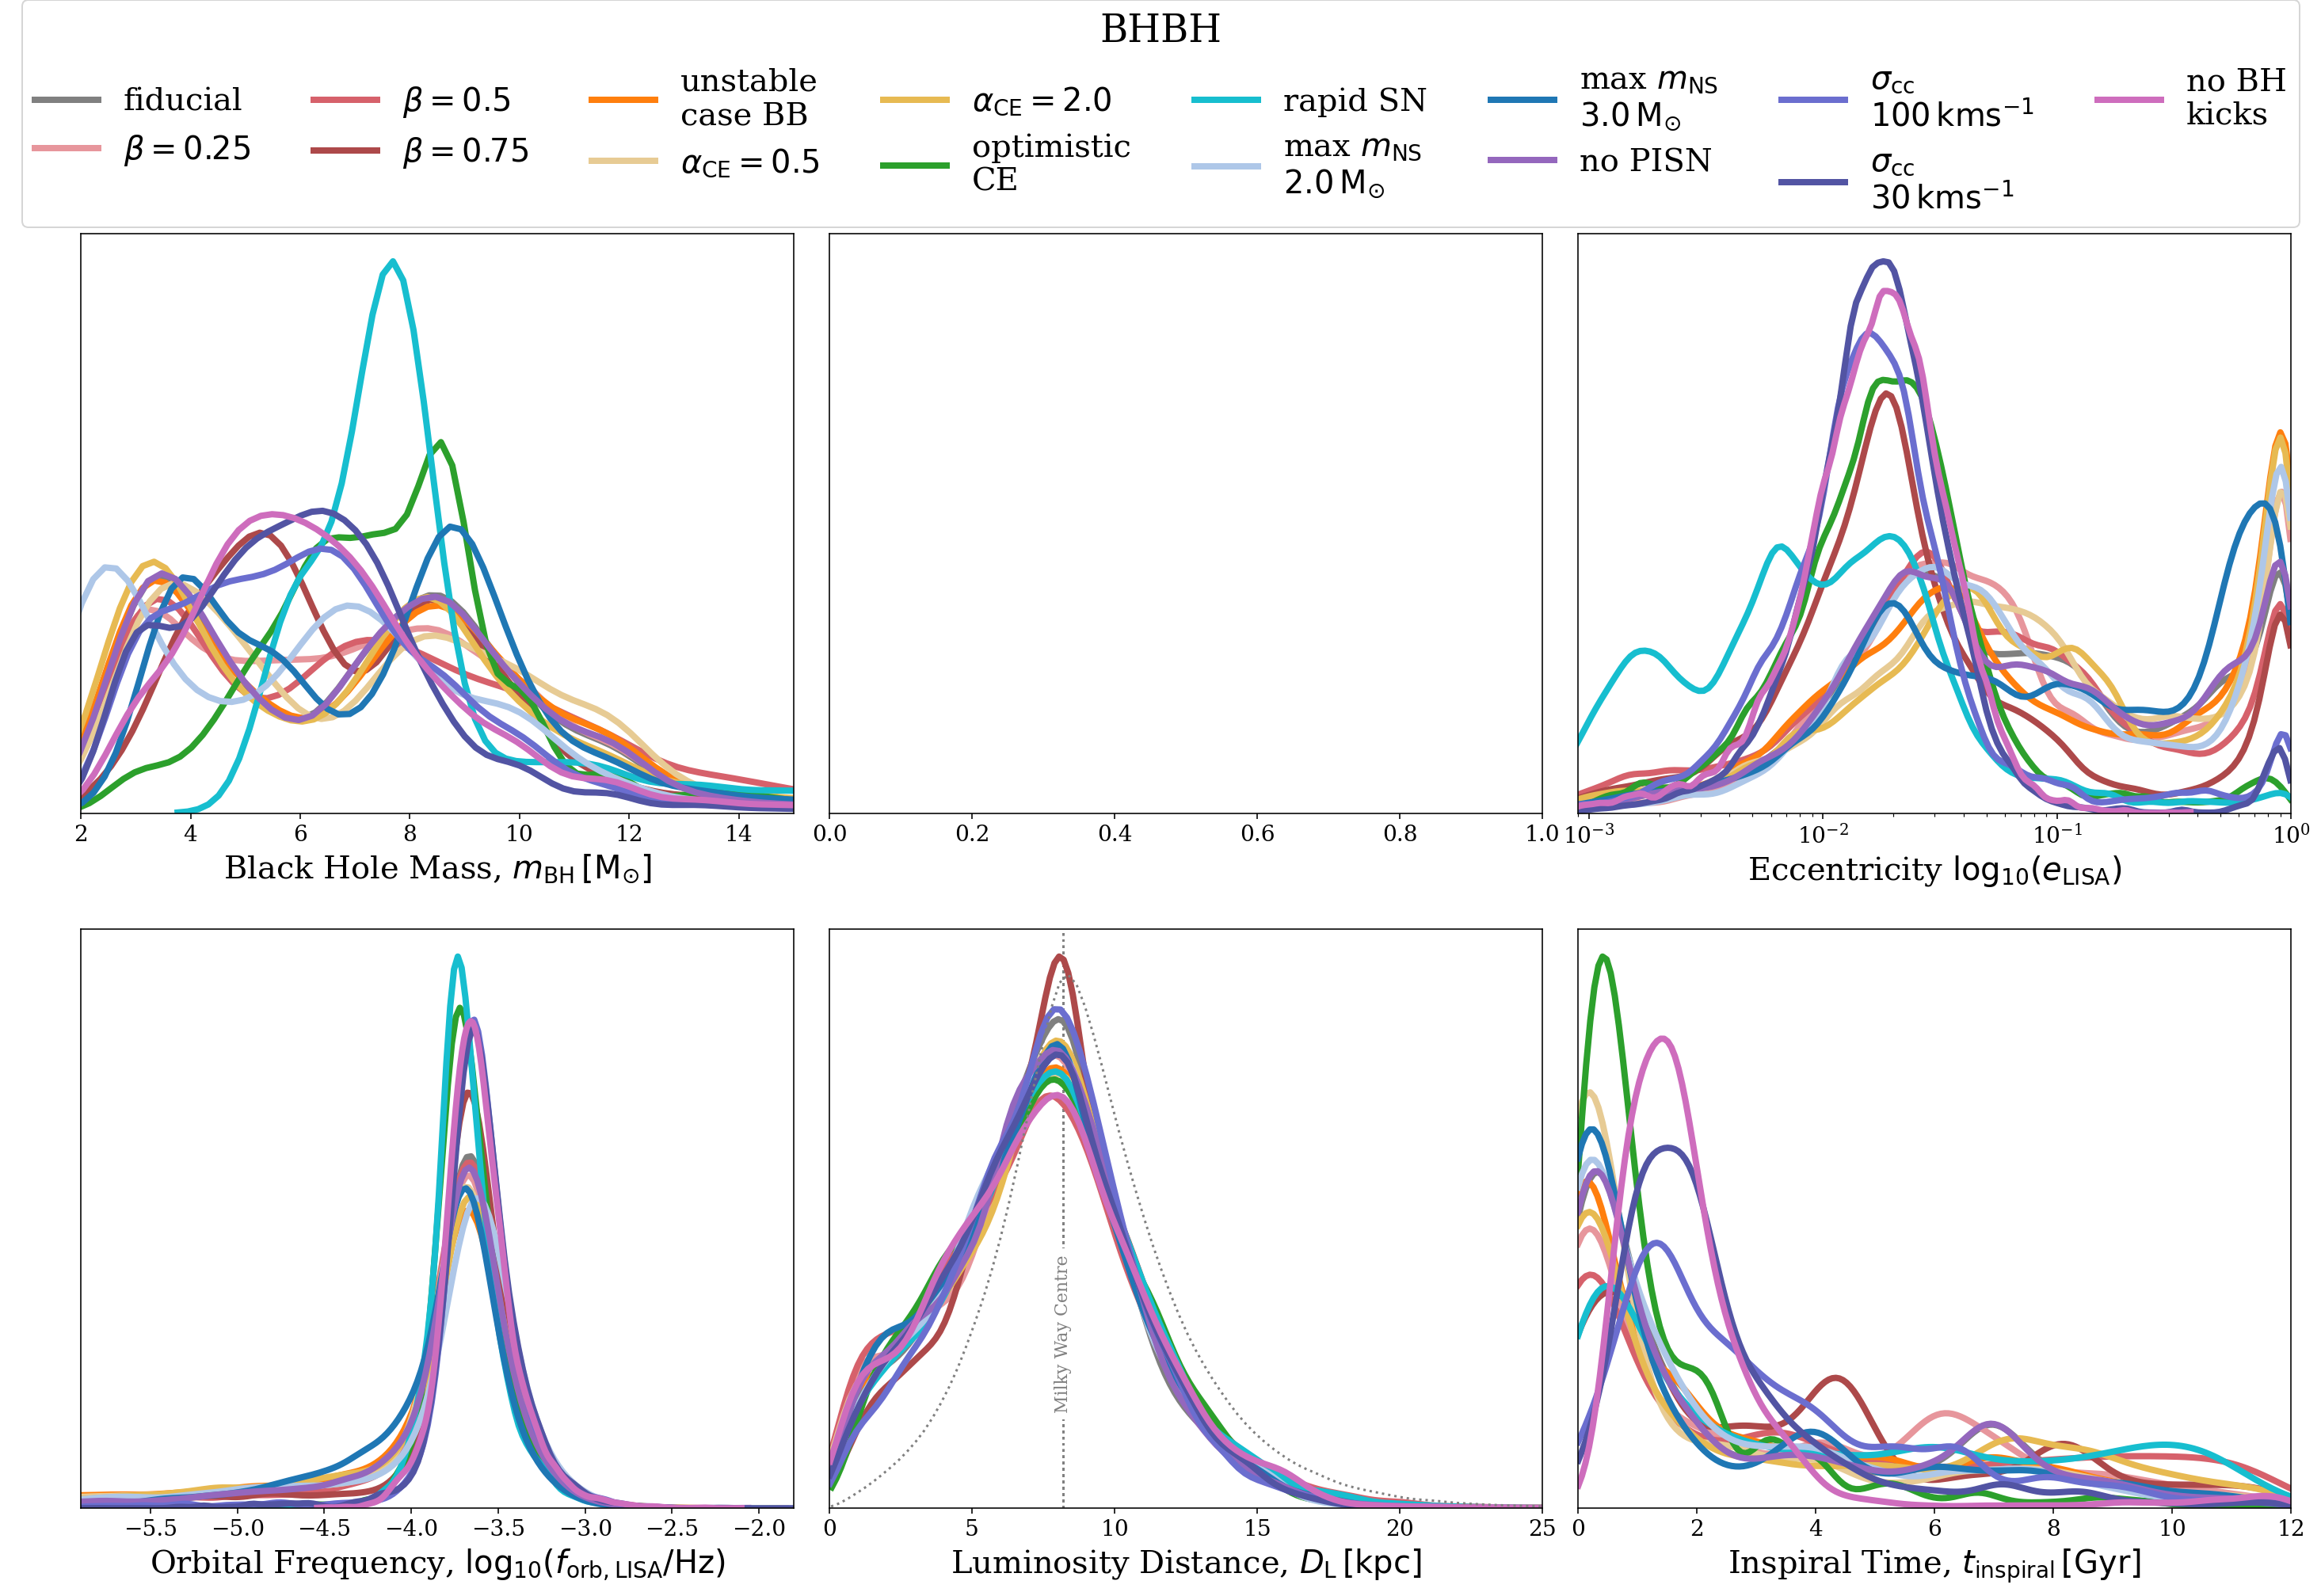

In [7]:
distribution_pdf_grid_plot_bymodel(dco_type="BHBH", t_obs=4*u.yr)

In [ ]:
distribution_pdf_grid_plot_bymodel(dco_type="BHNS", t_obs=4*u.yr)

In [ ]:
distribution_pdf_grid_plot_bymodel(dco_type="NSNS", t_obs=4*u.yr)

In [8]:
def distribution_ecdf_grid_plot_bymodel(dco_type="BHNS", models=range(len(variations)),
                                       t_obs=4*u.yr, overlay_single_mass_pdfs=False, stat="proportion"):
    fig, axes = plt.subplots(2, 3, figsize=(25, 15))

    plt.subplots_adjust(wspace=0.05, top=0.87)

    lw = 4
    label_type = "short"

    for model in models:
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

            data = full_data[snr_mask]
            
        print(model, len(data))

        m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
        f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                              a=data["a_LISA"] * u.AU)
        f_dot = legwork.utils.fn_dot(m_c=m_c, f_orb=f_orb_LISA, e=data["e_LISA"], n=1)
        sigma_theta = sky_localisation(data["snr"], f_orb_LISA * 2).to(u.deg)
        
        t_merge = legwork.evol.get_t_merge_ecc(ecc_i=data["e_DCO"], a_i=data["a_DCO"] * u.AU,
                                          m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun).to(u.Gyr)

        if dco_type == "BHNS":
            mBH = np.maximum(data["m_1"], data["m_2"])
            mNS = np.minimum(data["m_1"], data["m_2"])
            mass_weights = data["weight"]
        elif dco_type == "BHBH":
            mBH = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
        elif dco_type == "NSNS":
            mNS = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            
        if dco_type in ["BHNS", "BHBH"]:
            sns.ecdfplot(x=mBH, weights=mass_weights / np.sum(data["weight"]) * detections[dco_types.index(dco_type)][model].mean(), ax=axes[0, 0], color=variations[model]["colour"], lw=lw, label=variations[model]["med"], stat=stat)
            axes[0, 0].set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
            axes[0, 0].set_xlim(2, 15)

        if dco_type == "BHBH" and overlay_single_mass_pdfs:
            twinned = axes[0, 0].twinx()
            sns.ecdfplot(x=data["m_1"], weights=data["weight"] / np.sum(data["weight"]) * detections[dco_types.index(dco_type)][model].mean(), ax=twinned, bw_adjust=1.5, color=variations[model]["colour"], label=variations[model]["med"], linestyle="dotted", stat=stat)
            sns.ecdfplot(x=data["m_2"], weights=data["weight"] / np.sum(data["weight"]) * detections[dco_types.index(dco_type)][model].mean(), ax=twinned, bw_adjust=1.5, color=variations[model]["colour"], label=variations[model]["med"], linestyle="dotted", stat=stat)
            twinned.set_xlim(axes[0,0].get_xlim())
            twinned.set_ylim(axes[0, 0].get_ylim()[0], axes[0, 0].get_ylim()[1] * 3)
            twinned.set_yticks([])
            twinned.set_ylabel("")

        if dco_type in ["BHNS", "NSNS"]:
            sns.ecdfplot(x=mNS, weights=mass_weights / np.sum(data["weight"]) * detections[dco_types.index(dco_type)][model].mean(), ax=axes[0, 1], color=variations[model]["colour"], lw=lw, label=variations[model]["med"], stat=stat)
            axes[0, 1].set_xlabel(r"Neutron Star Mass, $m_{\rm NS} \, [\rm M_{\odot}]$")
            axes[0, 1].set_xlim(1.26, 2.5)

        sns.ecdfplot(x=np.log10(data["e_LISA"]), weights=data["weight"] / np.sum(data["weight"]) * detections[dco_types.index(dco_type)][model].mean(), ax=axes[0, 2], color=variations[model]["colour"], lw=lw, label=variations[model]["med"], stat=stat)
        axes[0, 2].set_xlabel(r"Eccentricity $\log_{10}(e_{\rm LISA})$")
        axes[0, 2].set_xlim(-4, 0)
    
        sns.ecdfplot(x=np.log10(f_orb_LISA.value), weights=data["weight"] / np.sum(data["weight"]) * detections[dco_types.index(dco_type)][model].mean(), ax=axes[1, 0], color=variations[model]["colour"], lw=lw, label=variations[model]["med"], stat=stat)
        axes[1, 0].set_xlabel(r"Orbital Frequency, $\log_{10}(f_{\rm orb, LISA} / {\rm Hz})$")
        axes[1, 0].set_xlim(-5.9, -1.8)

        sns.ecdfplot(x=data["dist"], weights=data["weight"] / np.sum(data["weight"]) * detections[dco_types.index(dco_type)][model].mean(), ax=axes[1, 1], color=variations[model]["colour"], lw=lw, label=variations[model]["med"], stat=stat)
        axes[1, 1].set_xlabel(r"Luminosity Distance, $D_{\rm L} \, [\rm kpc]$")
        axes[1, 1].set_xlim(0, 25)
        axes[1, 1].axvline(8.2, color="grey", linestyle="dotted", zorder=0)
        axes[1, 1].annotate("Milky Way Centre", xy=(8.2, 0.05), color="grey", rotation=90, ha="center", va="center",
                            bbox=dict(boxstyle="round", ec="white", fc="white"), fontsize=0.55*fs)
        
        sns.ecdfplot(x=t_merge.value, weights=data["weight"] / np.sum(data["weight"]) * detections[dco_types.index(dco_type)][model].mean(), ax=axes[1, 2], color=variations[model]["colour"], lw=lw, label=variations[model]["med"], stat=stat)
        axes[1, 2].set_xlabel(r"Inspiral Time, $t_{\rm inspiral} \, [\rm Gyr]$")
        axes[1, 2].set_xlim(0, 12)
        
#         sns.kdeplot(np.log10(data["Z"]), weights=data["weight"], ax=axes[1, 2], cut=0, bw_adjust=1.5, color=dco_colours[dco_type], lw=lw, label=dco_type)
        
    tau, D, Z = simulate_mw(int(1e6))
    sns.ecdfplot(x=D, ax=axes[1, 1], color="grey", linestyle="dotted", stat=stat)
    
    handles, labels = axes[1, 2].get_legend_handles_labels()
    leg = fig.legend(handles, labels, loc='upper center', fontsize=fs, ncol=8, borderaxespad=0.0,
                     title=dco_type, title_fontsize=1.2 * fs)

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.7*fs)
        ax.set_yticks([])
        ax.set_ylabel("")
        ax.xaxis.label.set_fontsize(fs)

    plt.show()

0 26657
1 26700
2 27936
3 30872
4 26490
5 24552
6 32779
7 21719
8 25268
9 25084
10 28900
11 26562
12 22805
13 20728
14 20384


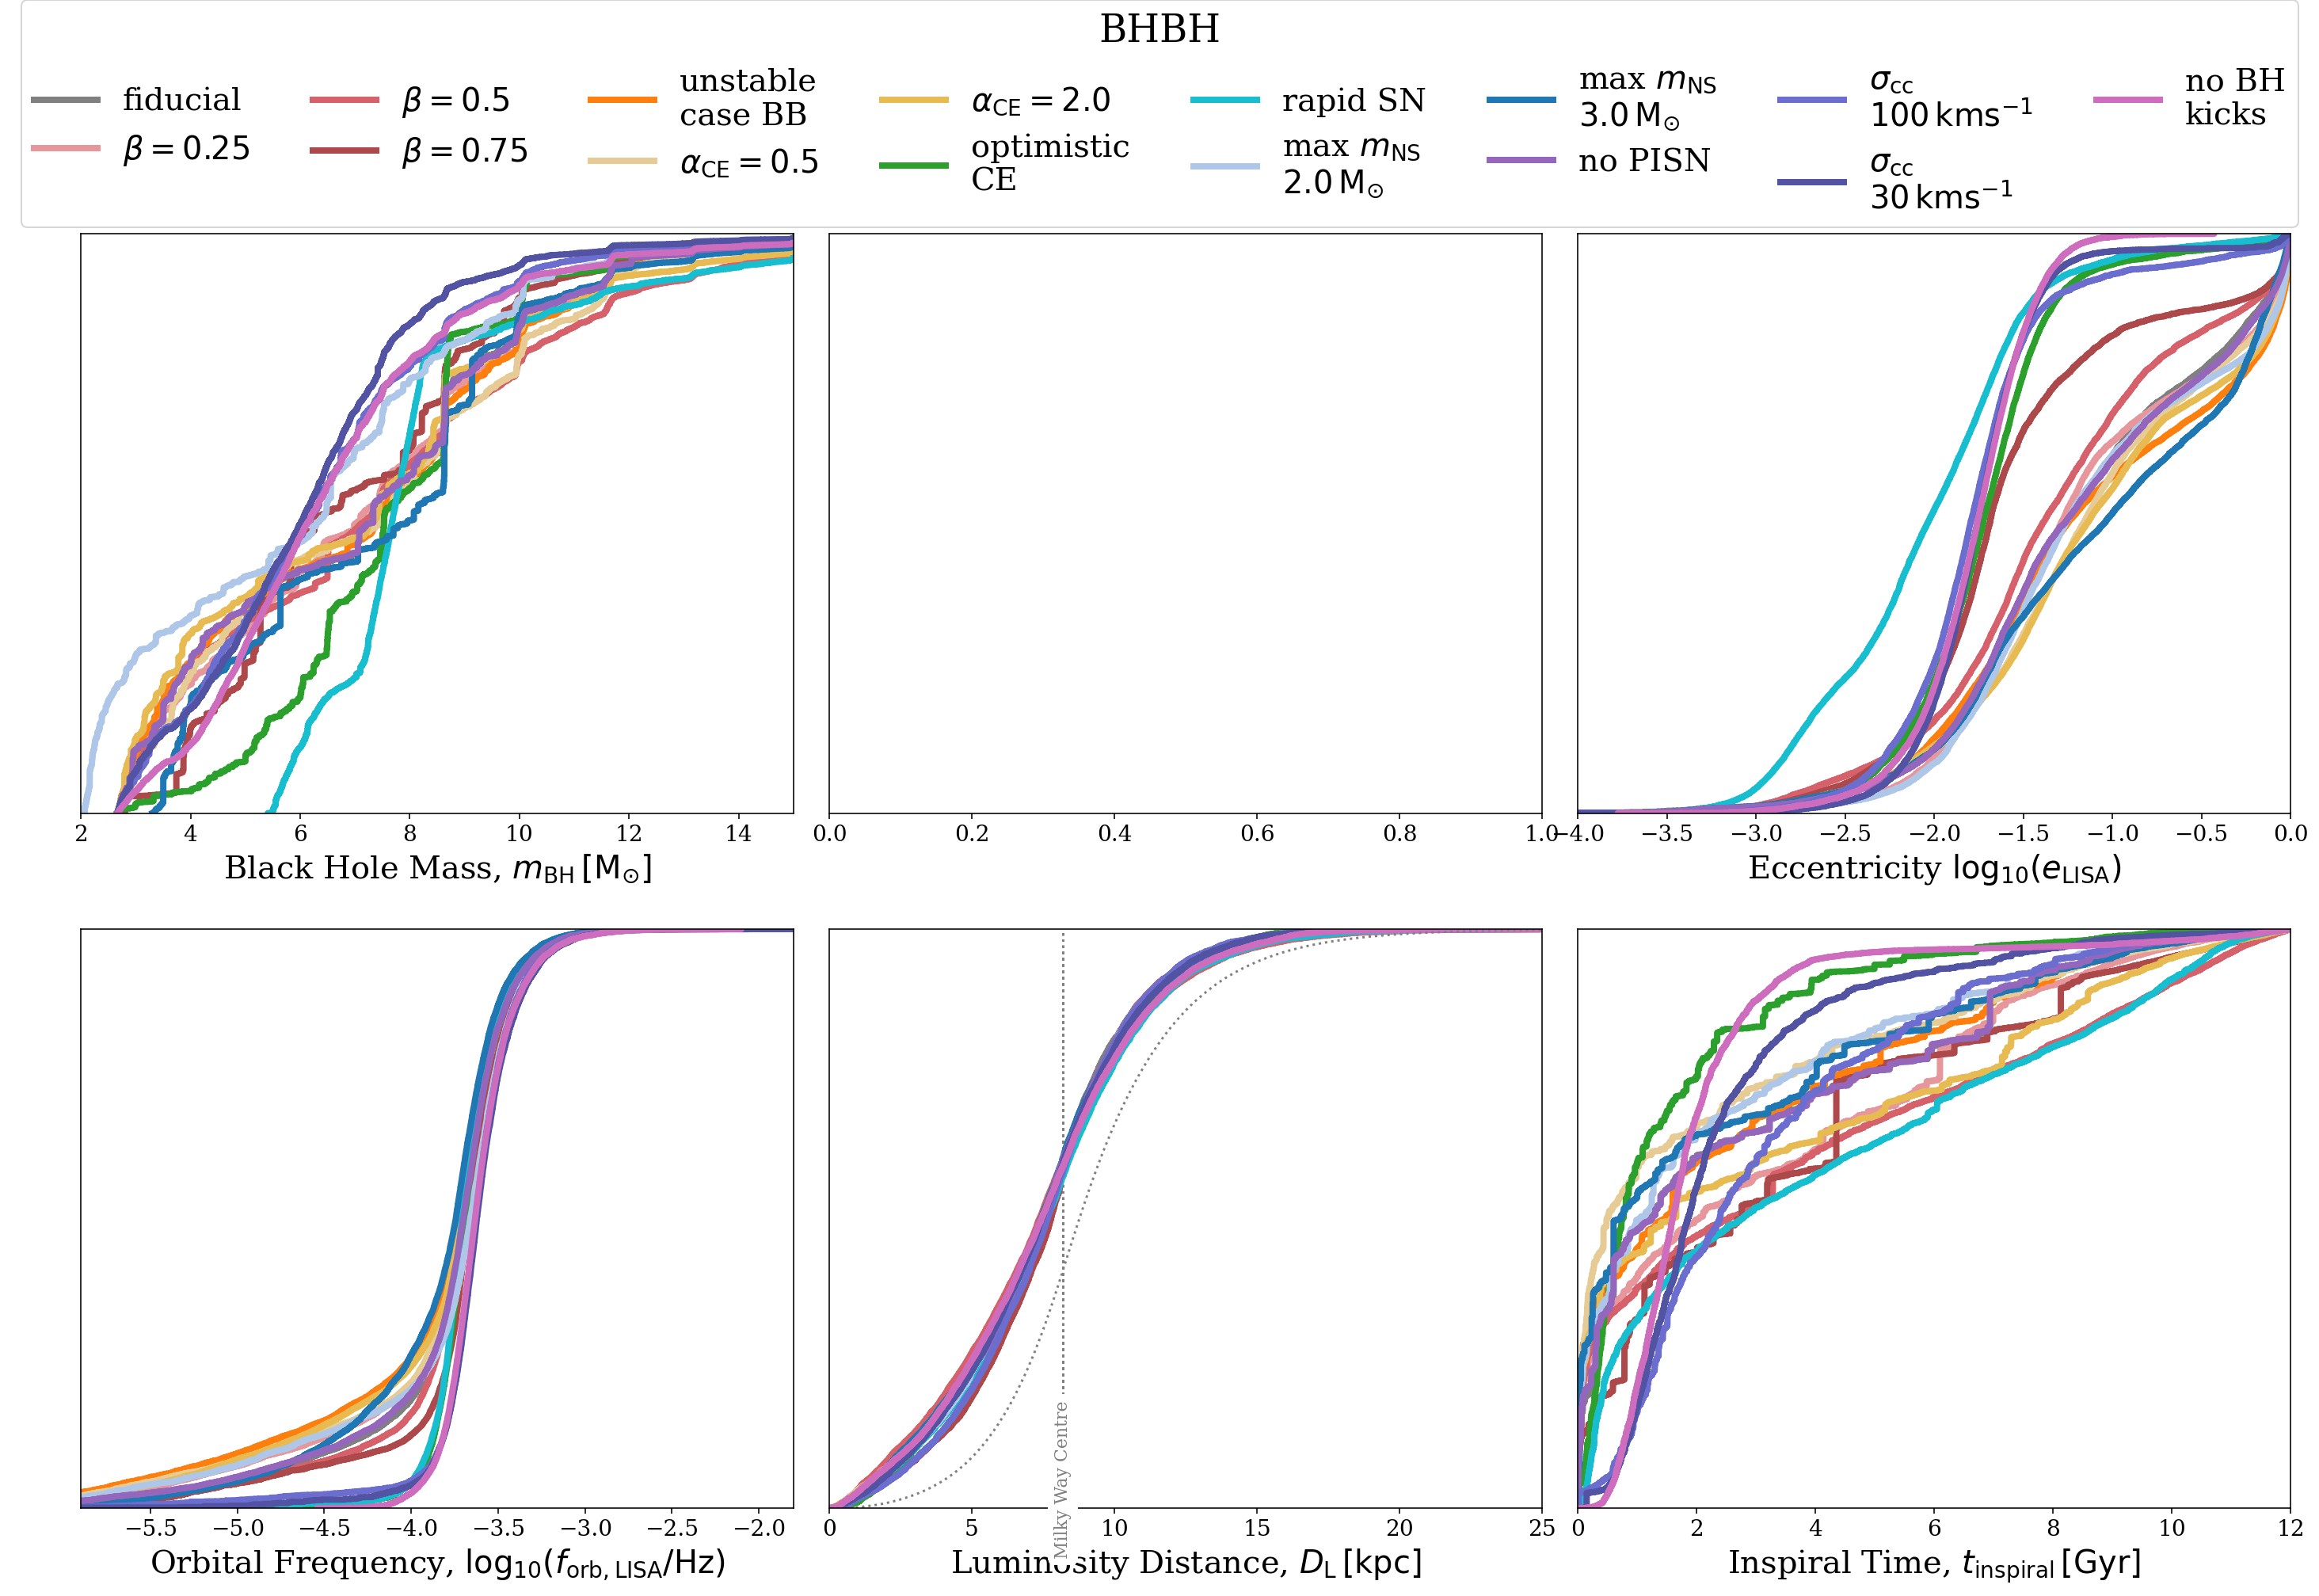

In [9]:
distribution_ecdf_grid_plot_bymodel(dco_type="BHBH", t_obs=4*u.yr)

In [ ]:
distribution_ecdf_grid_plot_bymodel(dco_type="BHNS", t_obs=4*u.yr, stat="count")

In [ ]:
distribution_ecdf_grid_plot_bymodel(dco_type="NSNS", t_obs=4*u.yr)